In [1]:
PATH = '../Dataset_GISLR/asl-signs/'
PROCESSED_OUTPUT_PATH = './Dataset_GISLR_Processed/'
MODEL_VERSION = 'high-perform-test'
save_low_performers = True
save_high_performers = False

In [2]:
import cv2

import numpy as np
import pandas as pd
from PIL import Image

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import mediapipe as mp
from mediapipe.framework.formats import landmark_pb2
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_holistic = mp.solutions.holistic
import numpy as np
import matplotlib.pyplot as plt
import math
import json
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.mixed_precision import set_global_policy
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error



2023-12-02 08:37:44.380617: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-02 08:37:44.380665: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-02 08:37:44.380683: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-02 08:37:44.385081: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/lib/python3/dist-packages/scipy/__init__.py:1

Load the Labels from the PreProcessed Data. Optionally filter out labels to remove any identified low performing labels.

In [3]:
signs_to_train = [name for name in os.listdir(PROCESSED_OUTPUT_PATH) if os.path.isdir(os.path.join(PROCESSED_OUTPUT_PATH, name))]

low_performing_labels_file_path = 'low_performing_labels.npy'
low_performing_labels = np.array([])
if os.path.exists(low_performing_labels_file_path):
    low_performing_labels = np.load(low_performing_labels_file_path, allow_pickle=True)
print(len(low_performing_labels))

high_performing_labels_file_path = 'high_performing_labels.npy'
high_performing_labels = np.array([])
if os.path.exists(high_performing_labels_file_path):
    high_performing_labels = np.load(high_performing_labels_file_path, allow_pickle=True)
print(len(high_performing_labels))

# remove low performing labels from signs_to_train
signs_to_train = [x for x in signs_to_train if x not in low_performing_labels]
print(len(signs_to_train))

# remove all non high performers
if (len(high_performing_labels) > 0):
    signs_to_train = [x for x in signs_to_train if x in high_performing_labels]
    print(len(signs_to_train))

signs_to_train.sort()
actions = np.array(signs_to_train)
print(actions)

197
53
['aunt' 'bird' 'black' 'brother' 'brown' 'bug' 'callonphone' 'cheek'
 'clown' 'cow' 'cute' 'dad' 'doll' 'donkey' 'drink' 'ear' 'eye' 'feet'
 'find' 'fireman' 'flower' 'for' 'frog' 'grandpa' 'grass' 'gum' 'hair'
 'hen' 'home' 'horse' 'lamp' 'mad' 'mom' 'mouse' 'nose' 'owl' 'pig'
 'police' 'radio' 'see' 'shhh' 'shirt' 'sick' 'stairs' 'stuck' 'taste'
 'thirsty' 'tiger' 'uncle' 'water' 'who' 'yucky' 'zebra']


Load all of the pre processed data

In [4]:

label_map = {label:num for num, label in enumerate(actions)}

sequences, labels = [], []

for label_folder in os.listdir(PROCESSED_OUTPUT_PATH):
    label = label_folder  # Use the folder name as the label
    if (label not in signs_to_train):
        continue
    
    if (label in low_performing_labels):
        print("Skipping label: ", label)
        continue

    label_folder_path = os.path.join(PROCESSED_OUTPUT_PATH, label_folder)

    # Iterate through the files in the label folder (each file is a sequence)
    for sequence_file in os.listdir(label_folder_path):
        if sequence_file.endswith('.npy'):
            # Load the sequence from the file
            sequence = np.load(os.path.join(label_folder_path, sequence_file))
            
            # Append the sequence and label to the respective lists
            sequences.append(sequence)
            labels.append(label_map[label])



In [5]:
X = np.array(sequences)
print(X.shape)

(13288, 10, 1662)


In [6]:
y = to_categorical(labels).astype(int)
print(y.shape)

(13288, 53)


Test train split all of the data

In [7]:
# First, split the data into training and a combined validation/test set
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)  # Adjust the test_size as needed

# Now, split the combined validation/test set into separate validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)  # This will split the remaining 30% into two 15% sets

In [8]:
print(y_test.shape)
print(y_val.shape)
print(y_train.shape)

(1994, 53)
(1993, 53)
(9301, 53)


Replace all nan else the model will not train correctly

In [9]:
# Check for NaN values in the datasets
print(f"NaNs in X_train: {np.isnan(X_train).any()}, NaNs in y_train: {np.isnan(y_train).any()}")
print(f"NaNs in X_val: {np.isnan(X_val).any()}, NaNs in y_val: {np.isnan(y_val).any()}")
print(f"NaNs in X_test: {np.isnan(X_test).any()}, NaNs in y_test: {np.isnan(y_test).any()}")

# Replace NaN values in the datasets
X_train = np.nan_to_num(X_train)
y_train = np.nan_to_num(y_train)
X_val = np.nan_to_num(X_val)
y_val = np.nan_to_num(y_val)
X_test = np.nan_to_num(X_test)
y_test = np.nan_to_num(y_test)


NaNs in X_train: True, NaNs in y_train: False
NaNs in X_val: True, NaNs in y_val: False
NaNs in X_test: True, NaNs in y_test: False


Build the model WIP

In [10]:
# v1
# model = Sequential()
# model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(10,1662)))
# model.add(LSTM(128, return_sequences=True, activation='relu'))
# model.add(LSTM(64, return_sequences=False, activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(actions.shape[0], activation='softmax'))
# model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

frame_length = 1662
num_classes = actions.shape[0]

# v2
model = Sequential()
model.add(LSTM(128, return_sequences=True, activation='relu', input_shape=(10, frame_length)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(256, return_sequences=False, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

# Optimizer with Gradient Clipping
# optimizer = Adam(learning_rate=0.0001, clipvalue=0.5)  # Adjust learning rate and clipvalue as needed
optimizer = Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=100, verbose=1, mode='min')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=25, verbose=1, mode='min', min_lr=0.00001)




2023-12-02 08:37:54.430084: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-02 08:37:54.432988: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-02 08:37:54.433036: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-02 08:37:54.434702: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-02 08:37:54.434736: I tensorflow/compile

Train the model

In [11]:
# Enable mixed precision
set_global_policy('mixed_float16')

epochs = 1000  # Adjust number of epochs as needed
batch_size = 1024

history = model.fit(
    X_train, y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=(X_val, y_val), 
    callbacks=[early_stopping, reduce_lr]
)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4090, compute capability 8.9


2023-12-02 08:37:55.529626: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


Epoch 1/1000


2023-12-02 08:38:00.429825: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb908296f30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-02 08:38:00.429869: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-12-02 08:38:00.434596: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-02 08:38:00.449839: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-12-02 08:38:00.518010: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 [==============================] - 7s 167ms/step - loss: 3.9674 - accuracy: 0.0229 - val_loss: 3.9901 - val_accuracy: 0.0311 - lr: 0.0010
Epoch 2/1000
10/10 [==============================] - 1s 90ms/step - loss: 3.8960 - accuracy: 0.0342 - val_loss: 3.9989 - val_accuracy: 0.0216 - lr: 0.0010
Epoch 3/1000
10/10 [==============================] - 1s 78ms/step - loss: 3.7596 - accuracy: 0.0483 - val_loss: 4.0058 - val_accuracy: 0.0211 - lr: 0.0010
Epoch 4/1000
10/10 [==============================] - 1s 89ms/step - loss: 3.6526 - accuracy: 0.0654 - val_loss: 3.9937 - val_accuracy: 0.0321 - lr: 0.0010
Epoch 5/1000
10/10 [==============================] - 1s 81ms/step - loss: 3.5115 - accuracy: 0.0840 - val_loss: 3.7521 - val_accuracy: 0.0396 - lr: 0.0010
Epoch 6/1000
10/10 [==============================] - 1s 76ms/step - loss: 3.3786 - accuracy: 0.1028 - val_loss: 3.7308 - val_accuracy: 0.0447 - lr: 0.0010
Epoch 7/1000
10/10 [==============================] - 1s 84ms/step - loss: 3

Gather metrics

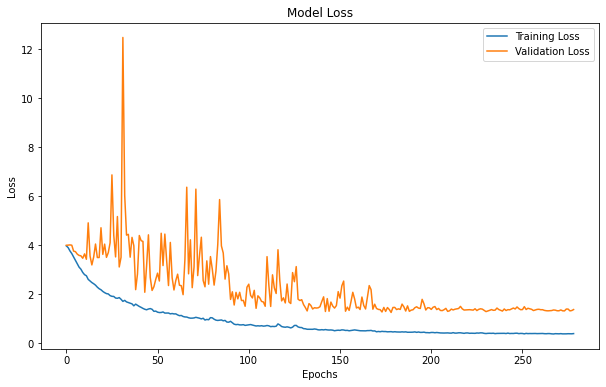

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 128)           916992    
                                                                 
 dropout (Dropout)           (None, 10, 128)           0         
                                                                 
 batch_normalization (Batch  (None, 10, 128)           512       
 Normalization)                                                  
                                                                 
 lstm_1 (LSTM)               (None, 256)               394240    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                        

Store the model data for later use in the Inference

In [14]:
model_dir = 'model-' + MODEL_VERSION + '/'
model_name = 'model-' + MODEL_VERSION + '.h5'
model.save(model_dir + model_name)
labels_name = 'labels-' + MODEL_VERSION + '.npy'
np.save(model_dir + labels_name, actions)

df_csv = pd.DataFrame(actions)
labels_csv_name = 'labels-' + MODEL_VERSION + '.csv'
df_csv.to_csv(model_dir + labels_csv_name, index=False)

/home/user/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')
report = classification_report(true_classes, predicted_classes, target_names=actions)

with open(model_dir + 'model_metrics.txt', 'w') as file:
    file.write(f"Accuracy: {accuracy}\n")
    file.write(f"Precision: {precision}\n")
    file.write(f"Recall: {recall}\n")
    file.write(f"F1 Score: {f1}\n")
    file.write(f"\nClassification Report:\n{report}")

print(report)

63/63 [==============================] - 1s 11ms/step
              precision    recall  f1-score   support

        aunt       0.92      0.83      0.87        41
        bird       0.85      0.72      0.78        46
       black       0.74      0.70      0.72        20
     brother       0.61      0.67      0.64        21
       brown       0.86      0.95      0.90        44
         bug       0.87      0.82      0.85        40
 callonphone       0.81      0.71      0.76        42
       cheek       0.69      0.67      0.68        36
       clown       0.84      0.84      0.84        61
         cow       0.76      0.74      0.75        46
        cute       0.90      0.76      0.83        34
         dad       0.60      0.68      0.64        38
        doll       0.78      0.58      0.67        43
      donkey       0.61      0.79      0.69        34
       drink       0.76      0.70      0.73        37
         ear       0.83      0.89      0.86        44
         eye       0.81    

In [21]:
if (save_high_performers):
    # Generate the classification report
    report = classification_report(true_classes, predicted_classes, target_names=actions, output_dict=True)

    # Convert report to a DataFrame
    report_df = pd.DataFrame(report).transpose()

    # The last few rows are overall metrics (accuracy, macro avg, weighted avg), so we remove them
    report_df = report_df[:-3]

    # Display the DataFrame sorted by F1-score
    report_df_sorted = report_df.sort_values(by='f1-score')

    high_performance_threshold = 0.82  # Define your threshold
    high_performing_categories = report_df_sorted[report_df_sorted['f1-score'] > high_performance_threshold]
    print(high_performing_categories.count())
    print(high_performing_categories)

    high_performing_labels = high_performing_categories.index.to_numpy()
    print(high_performing_labels)

    np.save(model_dir + 'high_performing_labels.npy', high_performing_labels)



precision    15
recall       15
f1-score     15
support      15
dtype: int64
       precision    recall  f1-score  support
taste   0.780488  0.864865  0.820513     37.0
cute    0.896552  0.764706  0.825397     34.0
sick    0.827586  0.827586  0.827586     29.0
owl     0.860465  0.804348  0.831461     46.0
shhh    0.781818  0.895833  0.834951     48.0
see     0.760000  0.926829  0.835165     41.0
feet    0.825000  0.846154  0.835443     39.0
clown   0.836066  0.836066  0.836066     61.0
pig     0.815789  0.861111  0.837838     36.0
bug     0.868421  0.825000  0.846154     40.0
ear     0.829787  0.886364  0.857143     44.0
aunt    0.918919  0.829268  0.871795     41.0
water   0.875000  0.875000  0.875000     48.0
nose    0.945946  0.833333  0.886076     42.0
brown   0.857143  0.954545  0.903226     44.0
['taste' 'cute' 'sick' 'owl' 'shhh' 'see' 'feet' 'clown' 'pig' 'bug' 'ear'
 'aunt' 'water' 'nose' 'brown']


In [ ]:
if (save_low_performers):
    # Generate the classification report
    report = classification_report(true_classes, predicted_classes, target_names=actions, output_dict=True)

    # Convert report to a DataFrame
    report_df = pd.DataFrame(report).transpose()

    # The last few rows are overall metrics (accuracy, macro avg, weighted avg), so we remove them
    report_df = report_df[:-3]

    # Display the DataFrame sorted by F1-score
    report_df_sorted = report_df.sort_values(by='f1-score')

    low_performance_threshold = 0.6  # Define your threshold
    low_performing_categories = report_df_sorted[report_df_sorted['f1-score'] < low_performance_threshold]
    print(low_performing_categories.count())
    print(low_performing_categories)

    low_performing_labels = low_performing_categories.index.to_numpy()
    print(low_performing_labels)

    np.save(model_dir + 'low_performing_labels.npy', low_performing_labels)



In [ ]:
res = model.predict(X_test)

In [ ]:
test_index = 10
print(actions[np.argmax(res[test_index])])
print(actions[np.argmax(y_test[test_index])])